# Parameter scan for the LHC data set

In [1]:
%matplotlib inline

import sys
import numpy as np
import optuna
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gmean
from collections import Counter


In [2]:
studies = []
for i in range(0, 500):
    try:
        studies.append(pickle.load(open(f"../data/paramscan/paramscan_june_{i}.pickle", "rb")))
    except FileNotFoundError as e:
        pass
        # print(f"Param scan run {i} is missing")       
                       
trials = [study.trials_dataframe() for study in studies]


In [3]:
for i, trial in enumerate(trials):
    trial.index = [f"job_{i}_trial_{j}" for j in trial["number"]]

results = pd.concat(trials)
results = results.drop(["number", "state", "datetime_start", "datetime_complete"], axis=1)
results = results.rename(columns={c:c.replace("params_", "") for c in results.keys()})
results = results.sort_values(by="value", ascending=True)


In [4]:
results

,value,batchnorm,batchsize,clip,dropout,innerlayers,lineartransform,msefactor,outerlayers,splinebins,splinerange,uvl2reg,weightdecay
job_22_trial_0,0.182066,False,100,16.197684,0.0,15,lu,29613.122512,20,11,10.0,2.165990e-02,2.639566e-06
job_81_trial_0,0.254657,False,100,7.941843,0.0,15,lu,10014.214073,15,11,8.0,9.222338e-04,6.681633e-05
job_94_trial_0,0.334047,True,100,3.633447,0.0,20,lu,3691.555743,22,12,8.0,3.928017e-07,6.761817e-05
job_90_trial_0,0.377020,False,100,1.139220,0.0,18,permutation,84008.798774,13,16,8.0,4.725779e-06,3.472659e-07
job_8_trial_0,0.417797,False,100,31.709701,0.0,8,permutation,32881.938348,25,12,8.0,6.179188e-05,9.888808e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
job_54_trial_0,3.039471,True,400,97.844498,0.2,18,svd,11.545997,7,8,8.0,2.364549e-09,6.075820e-04
job_63_trial_0,3.386956,True,100,51.168465,0.0,23,permutation,1104.283165,5,7,6.0,1.221576e-03,3.733255e-03
job_62_trial_0,7.938099,True,50,4.189059,0.0,9,permutation,910.835509,9,16,8.0,1.549232e-09,1.041239e-07
job_71_trial_0,8.481603,False,50,1.890032,0.0,7,permutation,1488.271507,5,13,6.0,5.744689e-07,2.932649e-06


In [5]:
edge_dict = {
    "batchnorm": [-0.5, 0.5, 1.5],
    "batchsize": [25, 75, 150, 300, 500],
    "dropout": [-0.5, 0.1, 1.5],
    "linchannelfactor": [0.5, 1.5, 2.5],
    "linlayers": [0.5, 1.5, 2.5, 3.5],
    "splinerange": [5.5, 7., 9., 11.],
    "splinebins": [4, 6, 9, 15, 21],
    "lineartransform": None,
}


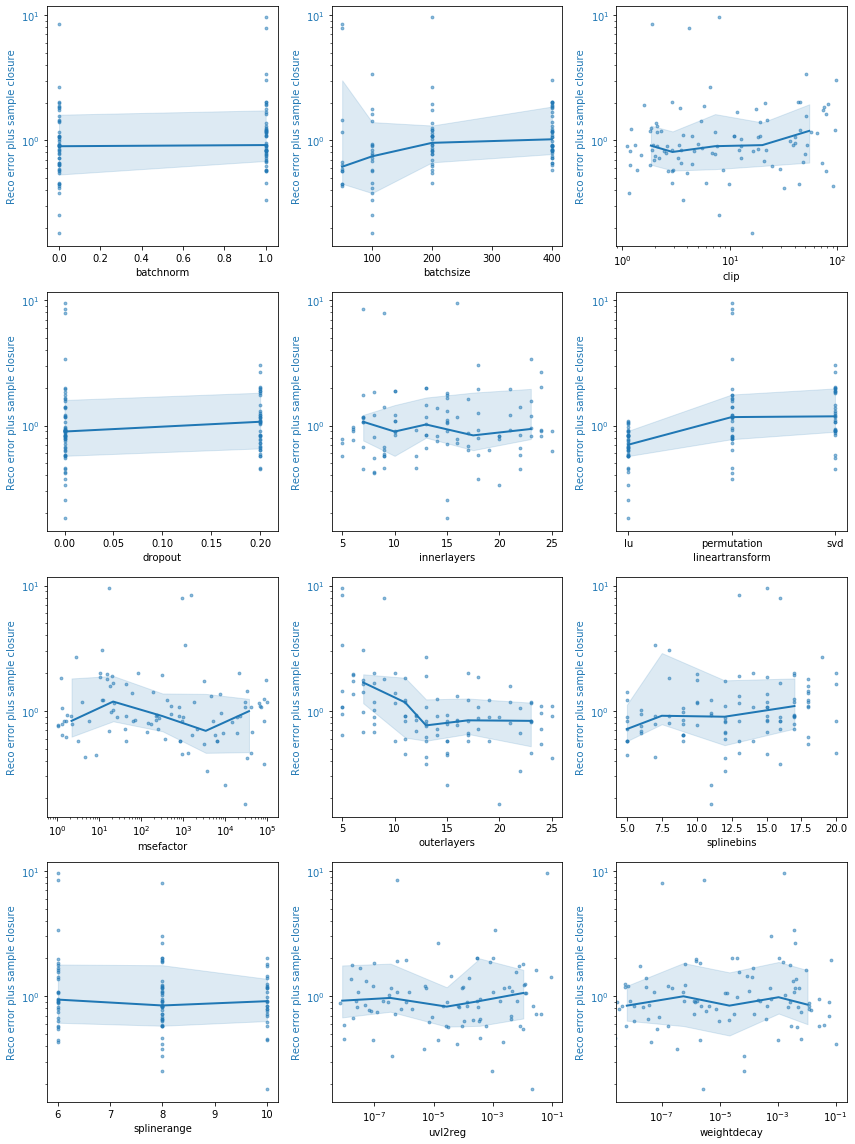

In [6]:
params = [c for c in results.columns if c != "value"]
n = len(params)
ncols = 3
nrows = (n - 1) // ncols + 1

y_err = 1.


plt.figure(figsize=(ncols * 4., nrows * 4))

for i, param in enumerate(params):
    ax = plt.subplot(nrows, ncols, i+1)
    
    x, y = results[param], results["value"]
    filter_ = y < 0.99e9
    x_ = x[filter_]
    y_ = y[filter_]
    y_err_min = 1.5 * np.max(y_)
    y_err_max = 1.7 * np.max(y_)
    
    if param in edge_dict:
        edges = edge_dict[param]
    else:
        edges = np.percentile(x_, np.linspace(0., 100., 6))
        
    if edges is None:  # Non-numeric x axes
        counter = Counter(x)
        x_dict = {label: val for val, label in enumerate(counter.keys())}
        x = np.array([x_dict[this_x] for this_x in x])
        x_ = x[filter_]
        edges = np.linspace(-0.5, len(counter.keys()) - 0.5, len(counter.keys()) + 1)
        plt.xticks((edges[1:] + edges[:-1])/2, list(counter.keys()))

    x_means = [np.median(x_[(x_ > min_)&(x_ < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_means = [np.median(y_[(x_ > min_)&(x_ < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_low = [np.percentile(y_[(x_ > min_)&(x_ < max_)], 16) for min_, max_ in zip(edges[:-1], edges[1:])]
    y_high = [np.percentile(y_[(x_ > min_)&(x_ < max_)], 84) for min_, max_ in zip(edges[:-1], edges[1:])]
    err_fraction = [1. - len(y_[(x_ > min_)&(x_ < max_)]) / len(y[(x > min_)&(x < max_)]) for min_, max_ in zip(edges[:-1], edges[1:])]
        
    ax.scatter(x_, y_, marker= "o", s=8., c="C0", alpha=0.5)

    ax.fill_between(x_means, y_low, y_high, color="C0", alpha=0.15)
    ax.plot(x_means, y_means, c="C0", lw=2.0)
    
    plt.xlabel(param)
    plt.ylabel("Reco error plus sample closure", color="C0")
    plt.yscale("log")
    # plt.ylim(0., None)
    if param in ["clip", "msefactor", "weightdecay", "uvl2reg"]:
        plt.xscale("log")
    ax.tick_params(axis='y', labelcolor="C0")
        
#     ax2 = ax.twinx()
#     ax2.set_ylabel('Error fraction', color="C3")
#     ax2.plot(x_means, err_fraction, color="C3")
#     ax2.tick_params(axis='y', labelcolor="C3")
#     plt.ylim(0., 0.8)

plt.tight_layout()
plt.savefig("../figures/lhc_paramscan.pdf")


## Best results

In [7]:
results.iloc[:3]

,value,batchnorm,batchsize,clip,dropout,innerlayers,lineartransform,msefactor,outerlayers,splinebins,splinerange,uvl2reg,weightdecay
job_22_trial_0,0.182066,False,100,16.197684,0.0,15,lu,29613.122512,20,11,10.0,2.165990e-02,0.000003
job_81_trial_0,0.254657,False,100,7.941843,0.0,15,lu,10014.214073,15,11,8.0,9.222338e-04,0.000067
job_94_trial_0,0.334047,True,100,3.633447,0.0,20,lu,3691.555743,22,12,8.0,3.928017e-07,0.000068
